# Are referees bias towards the home team in the Premier League?

# Dataset information 

Data taken from [https://www.football-data.co.uk](https://www.football-data.co.uk)

Key to results data:  

- Div = League Division
- Date = Match Date (dd/mm/yy)
- Time = Time of match kick off
- HomeTeam = Home Team
- AwayTeam = Away Team
- FTHG and HG = Full Time Home Team Goals
- FTAG and AG = Full Time Away Team Goals
- FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)
- HTHG = Half Time Home Team Goals
- HTAG = Half Time Away Team Goals
- HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)  

<u> **Match Statistics (where available)** </u>  
- Attendance = Crowd Attendance
- Referee = Match Referee
- HS = Home Team Shots
- AS = Away Team Shots
- HST = Home Team Shots on Target
- AST = Away Team Shots on Target
- HHW = Home Team Hit Woodwork
- AHW = Away Team Hit Woodwork
- HC = Home Team Corners
- AC = Away Team Corners
- HF = Home Team Fouls Committed
- AF = Away Team Fouls Committed
- HFKC = Home Team Free Kicks Conceded
- AFKC = Away Team Free Kicks Conceded
- HO = Home Team Offsides
- AO = Away Team Offsides
- HY = Home Team Yellow Cards
- AY = Away Team Yellow Cards
- HR = Home Team Red Cards
- AR = Away Team Red Cards
- HBP = Home Team Bookings Points (10 = yellow, 25 = red)
- ABP = Away Team Bookings Points (10 = yellow, 25 = red)

*Note that Free Kicks Conceeded includes fouls, offsides and any other offense commmitted and will always be equal to or higher than the number of fouls. Fouls make up the vast majority of Free Kicks Conceded. Free Kicks Conceded are shown when specific data on Fouls are not available.*

*Note also that English and Scottish yellow cards do not include the initial yellow card when a second is shown to a player converting it into a red, but this is included as a yellow (plus red) for European games.*


In [29]:
# Importing packages ------------------------------------------------------

import pandas as pd
import numpy as np 
import os 
from plotnine import *
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.factorplots import interaction_plot
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import linregress
from statsmodels.formula.api import ols


# Reading in data ------------------------------------------------------

years = np.arange(5,23) 
years_1 = np.arange(6,24)

## Convert to string and add trailing 0 
## required for website url data is stored on 

years = years.astype(str)
years = np.char.zfill(years, 2)

years_1 = years_1.astype(str)
years_1 = np.char.zfill(years_1, 2)

## Combining to give out the final years
url_years = np.core.defchararray.add(years, years_1)

data_url_base = 'https://www.football-data.co.uk/mmz4281/{Year}/E0.csv'


## Check if the data already exists locally (previously compiled incase of no internet)

if os.path.exists("football_data.csv"):
    df = pd.read_csv("football_data.csv", low_memory=False, index_col=False)
else:
    ## creating url list with all years needed
    ## Also adding delimiter '/' between seasons for new column 
    data_urls_list = []
    season = []
    for year in url_years:
        url_with_year = data_url_base.replace('{Year}', year)
        season_year = year[:2] + '/' + year[2:]
        season.append(season_year)
        data_urls_list.append(url_with_year)

    df_list =[] 

    for file in enumerate(data_urls_list):
        df = pd.read_csv(file[1])
        df['Season'] = season[file[0]]
        df_list.append(df)
    
    df = pd.concat(df_list, ignore_index=True)

cols_to_keep = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','Referee','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR','Season']

df = df[cols_to_keep]

df['Total_Yellow_Cards'] = df['HY'] + df['AY']
df['Total_Red_Cards'] = df['HR'] + df['AR']
df['Total_Cards'] = df['Total_Yellow_Cards'] + df['Total_Red_Cards']
df['Total_Home_Cards'] = df['HY'] + df['HR']
df['Total_Away_Cards'] = df['AY'] + df['AR']

## Removing latest season as season not finished 
df = df[df.Season != "22/23"]

# Replacing some names as seem to be incomplete from older seasons
df.replace('D Gallaghe', 'D Gallagher', inplace=True)
df.replace('D Gallagh', 'D Gallagher', inplace=True)
df.replace('Mn Atkinson', 'M Atkinson', inplace=True)
df.replace('l Mason', 'L Mason', inplace=True)

df.dropna(inplace=True)
df.isna().sum()

Date                  0
HomeTeam              0
AwayTeam              0
FTHG                  0
FTAG                  0
FTR                   0
HTHG                  0
HTAG                  0
HTR                   0
Referee               0
HS                    0
AS                    0
HST                   0
AST                   0
HF                    0
AF                    0
HC                    0
AC                    0
HY                    0
AY                    0
HR                    0
AR                    0
Season                0
Total_Yellow_Cards    0
Total_Red_Cards       0
Total_Cards           0
Total_Home_Cards      0
Total_Away_Cards      0
dtype: int64

## Data 

In [2]:
# Display dataframe 
display(df)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HY,AY,HR,AR,Season,Total_Yellow_Cards,Total_Red_Cards,Total_Cards,Total_Home_Cards,Total_Away_Cards
0,13/08/05,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,D,M Riley,...,0.0,2.0,0.0,0.0,05/06,2.0,0.0,2.0,0.0,2.0
1,13/08/05,Everton,Man United,0.0,2.0,A,0.0,1.0,A,G Poll,...,3.0,1.0,0.0,0.0,05/06,4.0,0.0,4.0,3.0,1.0
2,13/08/05,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,D,R Styles,...,1.0,2.0,0.0,0.0,05/06,3.0,0.0,3.0,1.0,2.0
3,13/08/05,Man City,West Brom,0.0,0.0,D,0.0,0.0,D,C Foy,...,2.0,3.0,0.0,0.0,05/06,5.0,0.0,5.0,2.0,3.0
4,13/08/05,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,D,M Halsey,...,2.0,3.0,1.0,0.0,05/06,5.0,1.0,6.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6456,22/05/2022,Crystal Palace,Man United,1.0,0.0,H,1.0,0.0,H,M Atkinson,...,2.0,4.0,0.0,0.0,21/22,6.0,0.0,6.0,2.0,4.0
6457,22/05/2022,Leicester,Southampton,4.0,1.0,H,0.0,0.0,D,J Moss,...,0.0,1.0,0.0,0.0,21/22,1.0,0.0,1.0,0.0,1.0
6458,22/05/2022,Liverpool,Wolves,3.0,1.0,H,1.0,1.0,D,A Taylor,...,1.0,0.0,0.0,0.0,21/22,1.0,0.0,1.0,1.0,0.0
6459,22/05/2022,Man City,Aston Villa,3.0,2.0,H,0.0,1.0,A,M Oliver,...,0.0,1.0,0.0,0.0,21/22,1.0,0.0,1.0,0.0,1.0


### Summary statistics

In [3]:
# Dataset summary
df.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,...,AC,HY,AY,HR,AR,Total_Yellow_Cards,Total_Red_Cards,Total_Cards,Total_Home_Cards,Total_Away_Cards
count,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,...,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000
mean,1.525232,1.168266,0.683127,0.513313,13.739938,10.975697,5.971981,4.738390,10.977554,11.372446,...,4.787771,1.462074,1.760372,0.059907,0.086223,3.222446,0.146130,3.368576,1.521981,1.846594
std,1.308971,1.157920,0.835277,0.731679,5.412867,4.717523,3.367787,2.824973,3.621377,3.771412,...,2.745714,1.198111,1.274098,0.246297,0.291537,1.893566,0.389928,1.972854,1.236031,1.327883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,3.000000,8.000000,9.000000,...,3.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,2.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,10.000000,5.000000,4.000000,11.000000,11.000000,...,4.000000,1.000000,2.000000,0.000000,0.000000,3.000000,0.000000,3.000000,1.000000,2.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,8.000000,6.000000,13.000000,14.000000,...,6.000000,2.000000,3.000000,0.000000,0.000000,4.000000,0.000000,5.000000,2.000000,3.000000
max,9.000000,9.000000,5.000000,5.000000,43.000000,31.000000,24.000000,20.000000,33.000000,26.000000,...,19.000000,7.000000,9.000000,2.000000,2.000000,12.000000,3.000000,12.000000,7.000000,9.000000


### Contingency Tables

In [4]:
# Contingency table to show relationship between Home and Away Cards

df_contingency = pd.crosstab(df['Total_Home_Cards'], 
                             df['Total_Away_Cards'], margins=False)

df_HomeFouls = pd.crosstab(df['Total_Home_Cards'], 
                               df['HF'])
df_AwayFouls = pd.crosstab(df['Total_Away_Cards'], 
                           df['AF'])

df_Aresult = pd.crosstab(df['Total_Away_Cards'],
                         df['FTR'])

df_Hresult = pd.crosstab(df['Total_Home_Cards'],
                         df['FTR'])

print("Total Home Cards v Total Away Cards")
display(df_contingency)

print("Home team fouls committed v Home team cards shown")
display(df_HomeFouls)

print("Away team fouls committed v Away team cards shown")
display(df_AwayFouls)

print("Total Home cards shown v Full Time Result")
display(df_Hresult)

print("Total Away cards shown v Full Time Result")
display(df_Aresult)

Total Home Cards v Total Away Cards


Total_Away_Cards,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Total_Home_Cards,,,,,,,,,,
0.0,373,439,368,204,62,24,1,0,0,0
1.0,329,588,566,346,133,44,13,3,0,0
2.0,206,484,465,311,158,51,10,4,1,1
3.0,67,222,231,171,92,26,9,6,0,1
4.0,25,76,92,86,35,12,3,0,1,0
5.0,5,24,24,25,14,5,0,0,0,0
6.0,2,4,7,5,1,1,0,0,0,0
7.0,1,2,0,0,1,0,0,0,0,0


Home team fouls committed v Home team cards shown


HF,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,28.0,33.0
Total_Home_Cards,,,,,,,,,,,,,,,,,,,,,
0.0,2,1,10,19,41,95,136,138,166,174,...,7,1,0,1,0,0,0,0,0,0
1.0,0,1,6,9,30,64,129,161,203,241,...,9,6,2,3,2,1,0,2,0,0
2.0,0,0,1,4,10,26,62,87,125,151,...,21,14,7,0,3,1,0,1,1,0
3.0,0,0,0,1,1,7,12,31,45,70,...,14,7,6,4,6,1,1,0,0,1
4.0,0,0,0,0,0,2,3,3,10,23,...,12,12,5,4,1,1,0,0,0,0
5.0,0,0,0,0,0,0,0,1,3,4,...,7,0,2,2,1,0,0,0,1,0
6.0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,2,0,0,0,0,0
7.0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Away team fouls committed v Away team cards shown


AF,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0
Total_Away_Cards,,,,,,,,,,,,,,,,,,,,,
0.0,4,7,23,31,44,98,95,115,102,122,...,12,6,5,3,1,1,0,1,0,0
1.0,1,2,12,29,66,91,161,179,217,225,...,46,15,13,6,4,2,2,1,1,0
2.0,1,0,8,9,41,62,98,106,186,205,...,58,33,18,13,11,3,2,1,0,0
3.0,0,0,1,8,7,15,47,70,72,108,...,59,32,26,15,12,1,1,1,1,3
4.0,0,0,1,0,2,10,11,18,33,36,...,28,22,21,13,10,12,5,2,0,1
5.0,0,0,0,0,0,1,0,2,5,6,...,10,17,5,7,4,3,2,3,0,1
6.0,0,0,0,0,0,0,1,0,1,1,...,2,2,2,0,3,1,0,0,0,0
7.0,0,0,0,0,0,0,0,0,0,1,...,2,3,0,0,0,0,0,0,0,0
8.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


Total Home cards shown v Full Time Result


FTR,A,D,H
Total_Home_Cards,,,
0.0,343,300,828
1.0,562,501,959
2.0,535,424,732
3.0,301,228,296
4.0,134,96,100
5.0,38,23,36
6.0,10,2,8
7.0,2,1,1


Total Away cards shown v Full Time Result


FTR,A,D,H
Total_Away_Cards,,,
0.0,346,219,443
1.0,575,407,857
2.0,502,435,816
3.0,336,304,508
4.0,123,153,220
5.0,35,38,90
6.0,7,11,18
7.0,0,7,6
8.0,1,0,1


We can see from the above contingency tables how the number of cards vs fouls committed are much different between both the home and away sides. 
It is quite clear to see how Away teams are shown cards with less fouls committed than the home side whereby the home side tend to get away with the fouls before getting shown a card, again this might also be attributed to the fact that away sides tend to be much more aggressive to impose themselves in the game and early on thus leading to a card when committing their first few fouls.  

It can also be said that when the away team receives more cards this tends to influence the result in the home sides favour. 

## Variables

Below is a brief explanation of **some** of the variables that will be used to test whether a bias is presentwhen a referee is officating a match.

### Yellow Cards

A yellow card communicates a caution to any player or team official who commits a cautionable offence either on or off the field of play (Association, 2022)[<sup>3</sup>](#fn3).

A player is cautioned if guilty of:  
- delaying the restart of play
- dissent by word or action
- entering, re-entering or deliberately leaving the field of play without the referee's permission
- failing to respect the required distance when play is restarted with a corner kick, free kick or throw-in
- persistent offences (no specific number or pattern of offences constitutes persistent)
- unsporting behaviour
- entering the referee review area (RRA)
- excessively using the review (TV screen) signal
- A substitute or substituted player is cautioned if guilty of:
- delaying the restart of play
- dissent by word or action
- entering or re-entering the field of play without the referee's permission
- unsporting behaviour
- entering the referee review area (RRA)
- excessively using the review (TV screen) signal  

### Red Cards  
The Red card communiates a sending-off in which the player must leave the vicinity of the field of play and the technical area. They can no longer take part in the match (Association, 2022)[<sup>3</sup>](#fn3).

A player, substitute or substituted player who commits any of the following offences is sent off:  

- denying the opposing team a goal or an obvious goal-scoring opportunity by a handball offence (except a goalkeeper
- within their penalty area)
- denying a goal or an obvious goal-scoring opportunity to an opponent whose overall movement is towards the offender�s - goal by an offence punishable by a free kick (unless as outlined below)
- serious foul play
- biting or spitting at someone
- violent conduct
- using offensive, insulting or abusive language and/or gestures
- receiving a second caution in the same match
- entering the video operation room (VOR)





## Introduction
In this report, we test for, and look to find evidence of, referee bias in favor of home teams in the English Premier League using data for all matches between 2005 and 2022 (current season). A role of the referee is to govern the rules set out by the Football Association (FA) during a football match. 

According to the IFAB Laws of the game 2022-23:  
>Decisions will be made to the best of the referee's ability according to the Laws of the Game and the 'spirit of the game' and will be based on the opinion of the referee who has the discretion to take appropriate action within the framework of the Laws of the Game.(Association, 2022)[<sup>1</sup>](#fn1)

There will always be a concern of the referees exercising impartial or bias decisions in favour of a team specifically the home team. In this situation, there are issues of moral hazard and conflicts of interest where I explore whether the the number of sanctions (Yellow cards, Red cards, free kicks and penalties etc) awarded by referees are subject to some bias whether the team playing is at home and behaviour of the referee is somewhat influenced by various other factors.  

Across different sports many authors who have studied this effect attributed this to three main factors:  (BALMER, NEVILL and WILLIAMS, 2003)[<sup>**insert fn**</sup>]

- the away team experiencing fatigure due to travel  
- a lack of familiarity with the stadium and its environment i.e. smaller changing rooms and lengthier walks to get there  
- social support from home spectator  
 
Often these split decisions that can decide games taken by referees can often have huge financial implications for teams. For example, if a decision cost a team the game which meant they miss out of qualifying for the UEFA Champions League this could mean the difference between extra revenue for the club as well as attracting top talent for the season ahead. It can also have implications for the manager who may find himself out of a job especially if this forms part of their contract.

These decisions that affect the overall match result provide fuel for debate between players, teams, pundits, journalists and your average fan, in some cases for years into the foreseeable future.  

This concern is nothing new football fans across the global in multiple leagues since time can remember have complained about refereeing decisions. Some recent articles are linked below for reference. There are several fans who even claim conspiracies against their clubs by certain referees and managers have openly expressed dismay when particular match officials are appointed to officiate their matches.  

[https://www.newcastleworld.com/sport/football/newcastle-united/i-hate-sunderland-premier-league-referee-on-bias-and-love-for-newcastle-united-3812928](https://www.newcastleworld.com/sport/football/newcastle-united/i-hate-sunderland-premier-league-referee-on-bias-and-love-for-newcastle-united-3812928)  
[https://www.football365.com/news/mailbox-arsenal-var-referee-conspiracy-man-utd-elon-musk-lionesses](https://www.football365.com/news/mailbox-arsenal-var-referee-conspiracy-man-utd-elon-musk-lionesses)  
[https://www.thesportsman.com/articles/tuchel-s-fury-and-87k-petitions-but-referees-are-not-biased-against-your-team](https://www.thesportsman.com/articles/tuchel-s-fury-and-87k-petitions-but-referees-are-not-biased-against-your-team)  
[https://www.caughtoffside.com/2022/08/16/anthony-taylor-to-continue-to-referee-chelsea-games/](https://www.caughtoffside.com/2022/08/16/anthony-taylor-to-continue-to-referee-chelsea-games/)  
[https://www.football365.com/news/mailbox-liverpool-1-1-palace-darwin-nunez-man-utd-arsenal](https://www.football365.com/news/mailbox-liverpool-1-1-palace-darwin-nunez-man-utd-arsenal)  


This bias however is not just limited to football it can be observed in all sporting competitions. There are numerous studies on this and have been explored for example in hockey (Pappas, 2011)[<sup>2</sup>](#fn2) and in basketball for the well known National Basketball Assocation (NBA) competition (Lim and Rodenberg, 2022)[<sup>3</sup>](#fn3)

In [5]:
# Dataset summary
df.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,...,AC,HY,AY,HR,AR,Total_Yellow_Cards,Total_Red_Cards,Total_Cards,Total_Home_Cards,Total_Away_Cards
count,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,...,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000,6460.000000
mean,1.525232,1.168266,0.683127,0.513313,13.739938,10.975697,5.971981,4.738390,10.977554,11.372446,...,4.787771,1.462074,1.760372,0.059907,0.086223,3.222446,0.146130,3.368576,1.521981,1.846594
std,1.308971,1.157920,0.835277,0.731679,5.412867,4.717523,3.367787,2.824973,3.621377,3.771412,...,2.745714,1.198111,1.274098,0.246297,0.291537,1.893566,0.389928,1.972854,1.236031,1.327883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,3.000000,8.000000,9.000000,...,3.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,2.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,10.000000,5.000000,4.000000,11.000000,11.000000,...,4.000000,1.000000,2.000000,0.000000,0.000000,3.000000,0.000000,3.000000,1.000000,2.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,8.000000,6.000000,13.000000,14.000000,...,6.000000,2.000000,3.000000,0.000000,0.000000,4.000000,0.000000,5.000000,2.000000,3.000000
max,9.000000,9.000000,5.000000,5.000000,43.000000,31.000000,24.000000,20.000000,33.000000,26.000000,...,19.000000,7.000000,9.000000,2.000000,2.000000,12.000000,3.000000,12.000000,7.000000,9.000000


## Add in hypothesis testing move section to after exploratory charts 
## perform chi squared test 
## see how to plot distribution etc 

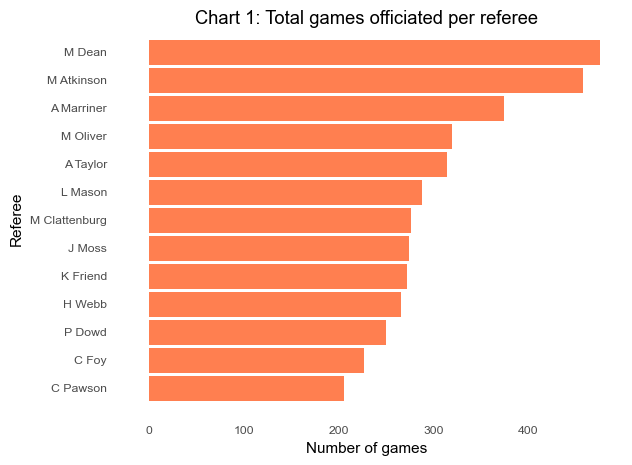

In [6]:
## Plotting the number of game a referee has taken charge of top 13
games_per_ref = df['Referee'].value_counts().rename_axis('Referee').reset_index(name='Count')

(ggplot(data=games_per_ref.head(n=13), 
            mapping=aes(x='reorder(Referee, Count)', y='Count'))+ 
            geom_col(fill='coral') + 
            coord_flip() + 
            theme_minimal(base_family='Arial') + 
            theme(panel_grid_major=element_blank(), 
                  panel_grid_minor=element_blank()) + 
            ylab('Number of games') + 
            ggtitle("Chart 1: Total games officiated per referee") +
            xlab('Referee')).draw();





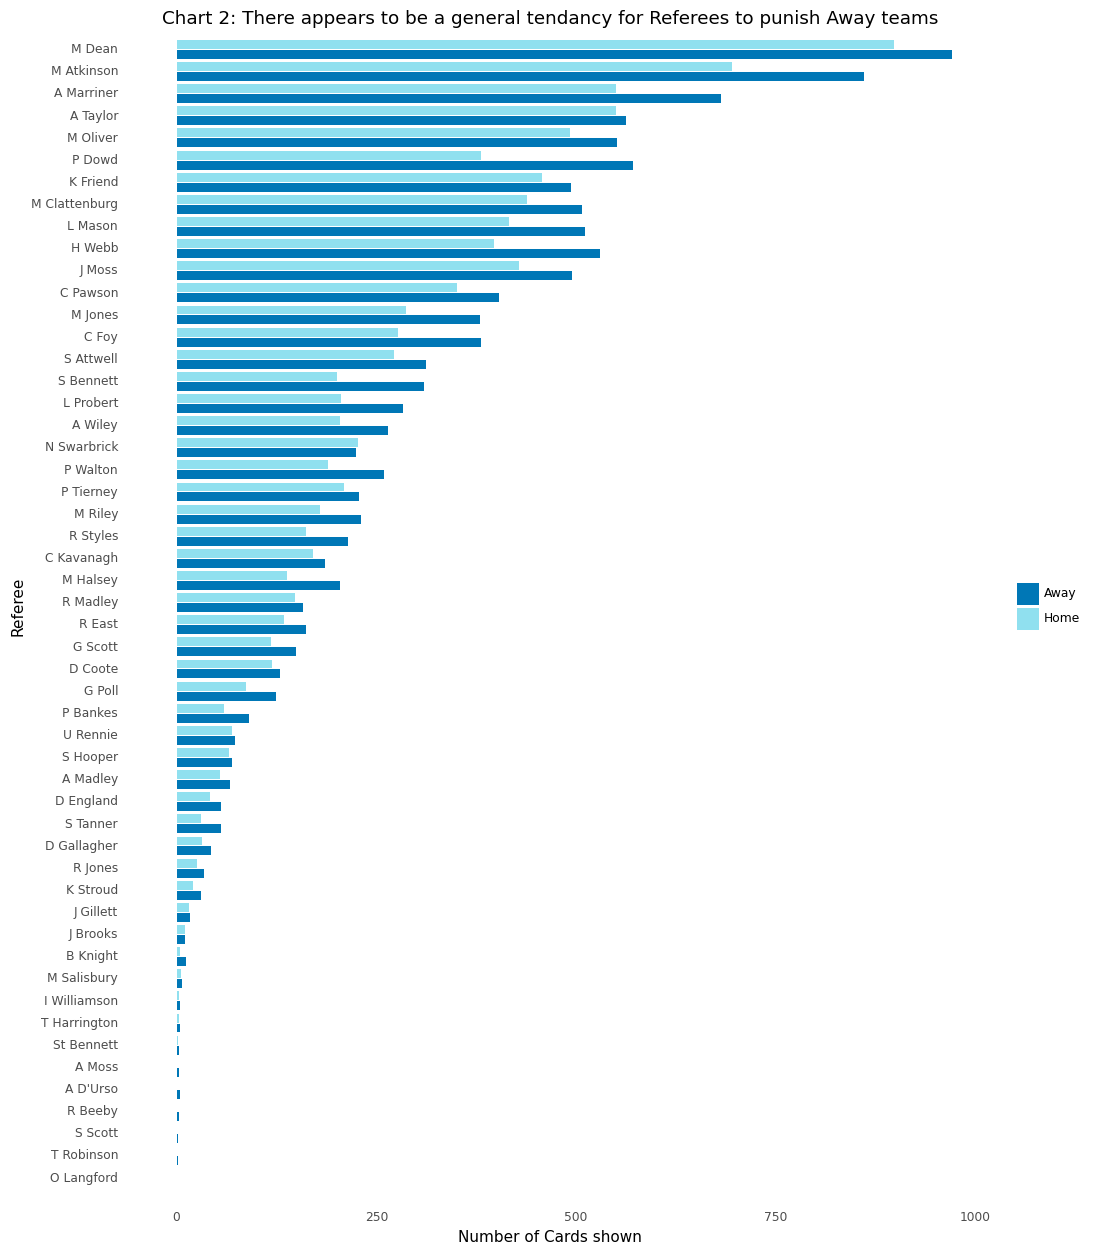

In [7]:
## Cards per ref 

cards_by_ref = df.groupby('Referee').agg(
    Home = pd.NamedAgg(column='Total_Home_Cards', aggfunc=sum),
    Away = pd.NamedAgg(column='Total_Away_Cards', aggfunc=sum)
).reset_index().melt(id_vars='Referee').sort_values(by="value", ascending=False)

(ggplot(data=cards_by_ref,
        mapping=aes(x = 'reorder(Referee, value)', y = 'value', fill = 'variable')) + 
        geom_col(position = position_dodge2()) +
        coord_flip() +
        theme_minimal() +
        ggtitle("Chart 2: There appears to be a general tendancy for Referees to punish Away teams") +
        ylab("Number of Cards shown")+
        xlab("Referee" ) +
        scale_fill_manual(values= ["#0077b6", "#90e0ef"]) +
        theme(figure_size=(11,15), 
              panel_grid_major=element_blank(),
              legend_title=element_blank(),
              panel_grid_minor=element_blank())).draw();

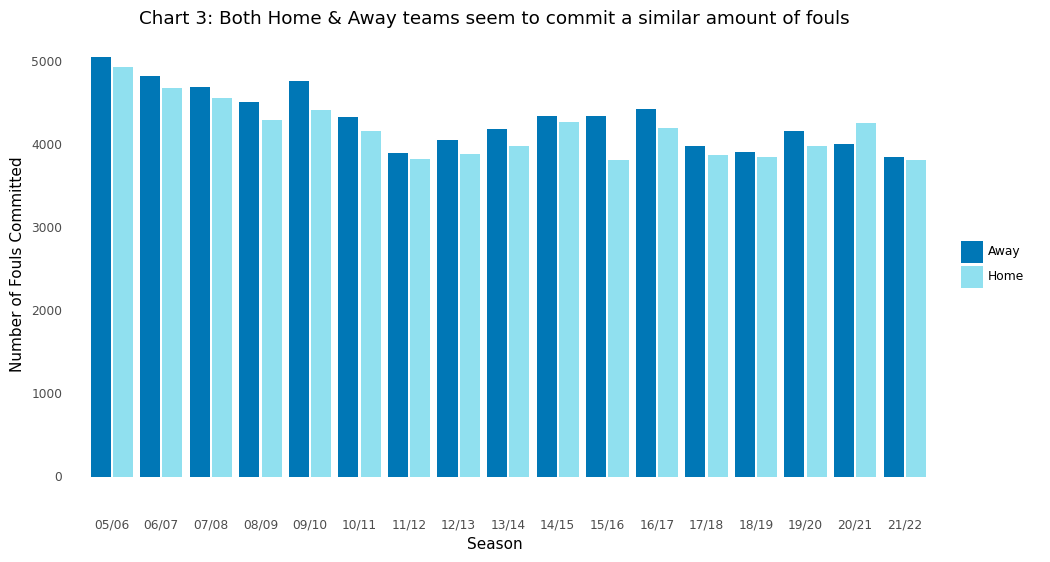

In [8]:
## Get total fouls commited split by Home/Away 

TotalFouls = df.groupby('Season').agg(
    Home = pd.NamedAgg(column='HF', aggfunc=sum),
    Away = pd.NamedAgg(column='AF', aggfunc=sum)
).reset_index().melt(id_vars = ['Season'], ignore_index=True).reset_index(drop=True)

(ggplot(data=TotalFouls, 
        mapping=aes(x = 'Season', y='value', fill='variable')) + 
        geom_col(position = position_dodge2())+ 
        theme_minimal() + 
        theme(legend_title=element_blank(), 
              legend_position='right', 
              figure_size=(11, 6),
              panel_grid_major=element_blank(), 
              panel_grid_minor=element_blank()) + 
              scale_fill_manual(values= ["#0077b6", "#90e0ef"]) +
              ylab("Number of Fouls Committed")+ 
              ggtitle("Chart 3: Both Home & Away teams seem to commit a similar amount of fouls")).draw();

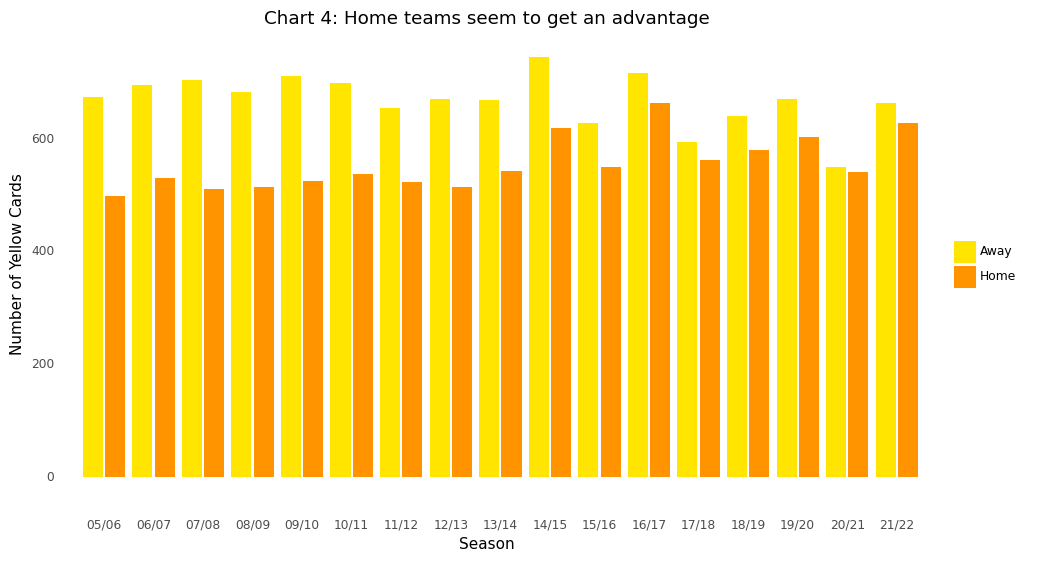

In [9]:
## Yellow cards per year split by Home/Away
Ycards_by_year = df.groupby('Season').agg(
    Home = pd.NamedAgg(column='HY', aggfunc=sum),
    Away = pd.NamedAgg(column='AY', aggfunc=sum)
).reset_index().melt(id_vars=['Season'], ignore_index=True)

## Plot the Yellow cards per season
(ggplot(data=Ycards_by_year, 
        mapping=aes(x='Season', y='value', fill='variable')) + 
        geom_col(position = position_dodge2()) + 
        theme_minimal() + 
        ylab("Number of Yellow Cards") + 
        theme(legend_title=element_blank(), 
              legend_position='right', 
              figure_size=(11, 6),
              panel_grid_major=element_blank(), 
              panel_grid_minor=element_blank()) + 
              scale_fill_manual(values= ["#ffe500", "#ff9400"]) +
        ggtitle("Chart 4: Home teams seem to get an advantage")).draw();

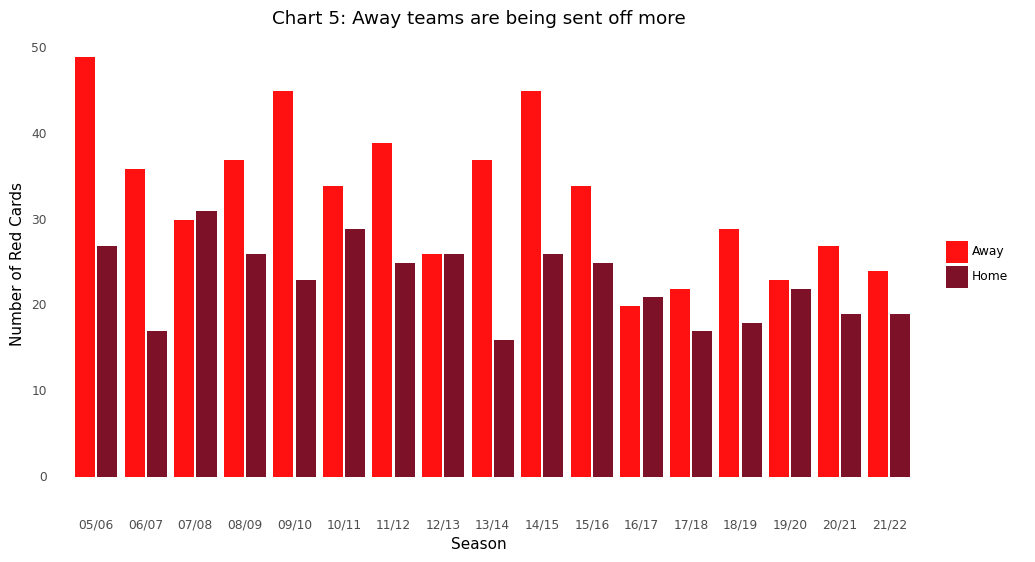

In [10]:
## Get Red cards per year split by Home/Away

Rcards_by_year = df.groupby('Season').agg(
    Home = pd.NamedAgg(column='HR', aggfunc=sum),
    Away = pd.NamedAgg(column='AR', aggfunc=sum)
).reset_index().melt(id_vars=['Season'], ignore_index=True)

## Plot the Yellow cards per season
(ggplot(data=Rcards_by_year, 
        mapping=aes(x='Season', y='value', fill='variable')) + 
        geom_col(position = position_dodge2()) + 
        theme_minimal() + 
        ylab("Number of Red Cards") + 
        theme(legend_title=element_blank(), 
              legend_position='right', 
              figure_size=(11, 6),
              panel_grid_major=element_blank(), 
              panel_grid_minor=element_blank()) + 
              scale_fill_manual(values= ["#ff1111", "#7d1128"]) +
        ggtitle("Chart 5: Away teams are being sent off more")).draw();

What the above data shows us is that whilst on the surface of it we can see that whilst both home and away teams are commiting more or less a similar amount of fouls in a season, the away side seem to be on the receiving end of punishment in the form of a yellow card or red card.  

However whilst this might be true whilst looking at the data there are a number of factors that maybe influence the decision behind a referee to produce a card in such games:  
- The nature of the fouls might not be a serious impediment of the rules so they do not warrant a booking. 
- Most times it is well known that teams play more aggressively away from home which can mean a foul committed has a higher chance of leading to a booking. 

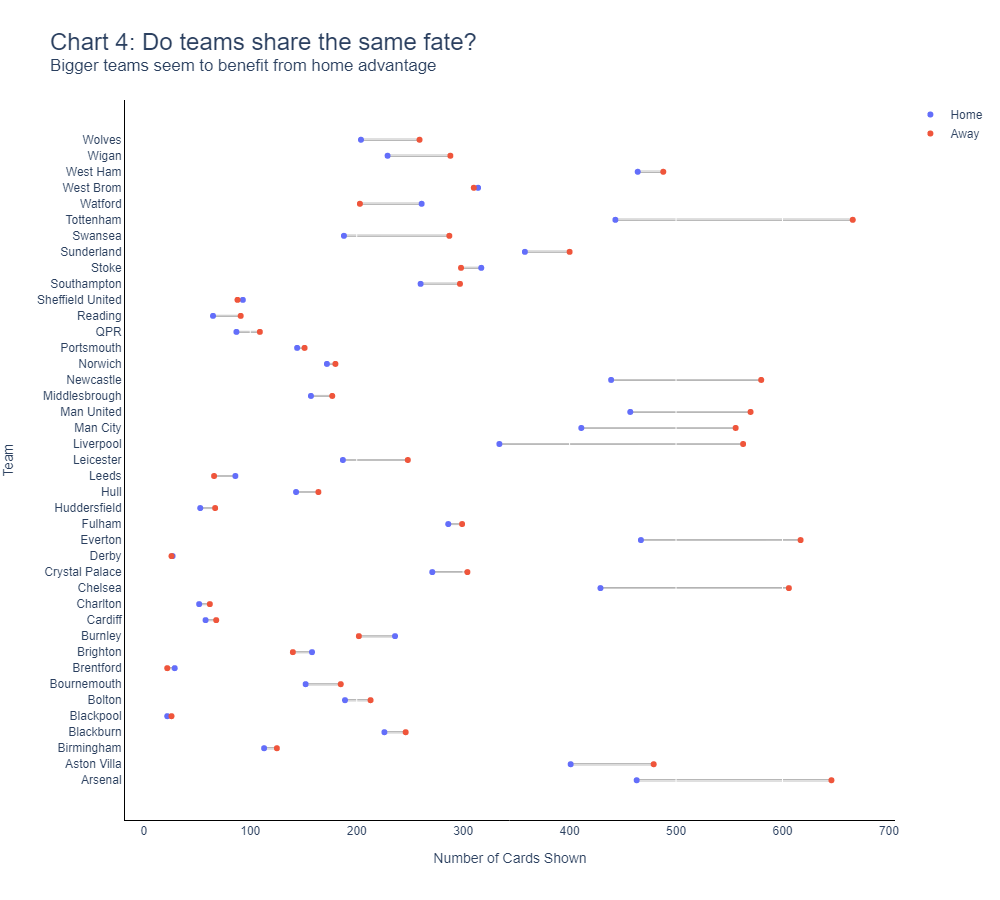

In [11]:
## Adding dumbell plot to show how teams are affected differently when playing Home or Away
## aggregate total cards across all years 

totalcards = df.groupby('HomeTeam').agg(
    Home = pd.NamedAgg(column='HY', aggfunc=sum),
    Away = pd.NamedAgg(column='AY', aggfunc=sum)
).reset_index().melt(id_vars='HomeTeam')


fig = px.scatter(totalcards, x='value', y='HomeTeam', color='variable',
                 height=900,
                 width=1000,
                 title="Chart 4: Do teams share the same fate? <br><sup>Bigger teams seem to benefit from home advantage</sup>",
                 labels={"variable" : ""}
                 )

## add line 
for i in totalcards['HomeTeam'].unique():
    df_sub = totalcards[totalcards['HomeTeam'] == i]
    
    fig.add_shape(
            type="line",
            line_color = "black",
            line_width = 2,
            opacity = 0.5,
            layer="below",
            y0 = df_sub.HomeTeam.values[0], x0 = df_sub.value.values[0],
            y1 = df_sub.HomeTeam.values[1], x1 = df_sub.value.values[1],
            )
fig.update_layout(
    font_family = "Arial",
    title_font_size = 24,
    yaxis=dict(
        title_text="Team"
    ),
    xaxis=dict(
        title_text = "Number of Cards Shown"
    ),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show("png")

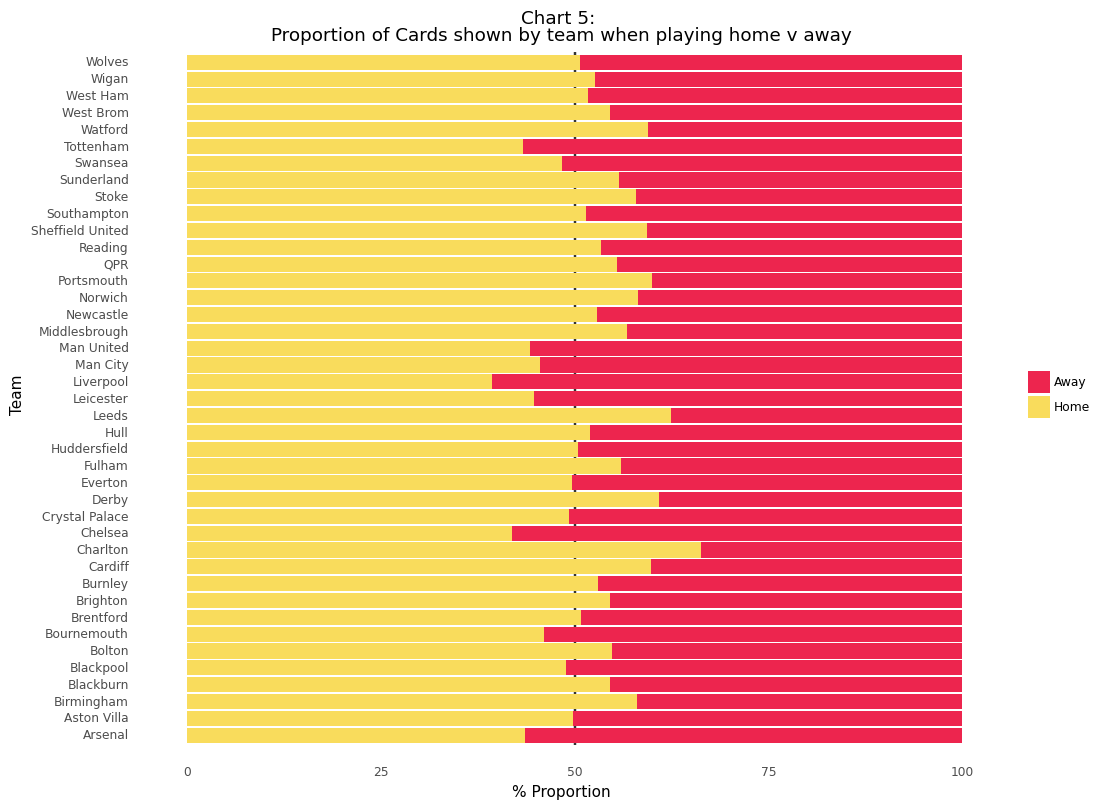

In [12]:
cards_type_cols = ['HomeTeam', 'AwayTeam', 'Total_Home_Cards', 'Total_Away_Cards', 'Referee']

cards_by_Hteam = df[cards_type_cols].groupby('HomeTeam').agg(
    Home = pd.NamedAgg(column='Total_Home_Cards', aggfunc=sum)
).reset_index()

cards_by_Ateam = df[cards_type_cols].groupby('AwayTeam').agg(
    Away = pd.NamedAgg(column='Total_Home_Cards', aggfunc=sum)
).reset_index()

cards_by_team = pd.merge(
    cards_by_Hteam, cards_by_Ateam, how="left", left_on="HomeTeam", right_on = "AwayTeam"
).drop(['AwayTeam'], axis=1).rename(columns={"HomeTeam":"Team"})

cards_by_team['propHome'] = (cards_by_team['Home'] / (cards_by_team['Home'] + cards_by_team['Away']) * 100)
cards_by_team['propAway'] = (cards_by_team['Away'] / (cards_by_team['Home'] + cards_by_team['Away']) * 100)
cards_by_team = cards_by_team.drop(['Home','Away'], axis=1).melt(id_vars='Team')

##plotting proportions
(ggplot(data=cards_by_team, 
        mapping=aes(
            x = 'Team', 
            y = 'value', 
            fill = 'variable'
        )) + 
        geom_hline(yintercept = 50, size = 1, colour = "#333333") +
        geom_col() + 
        coord_flip() + 
        theme_minimal() +
        ylab("% Proportion") + 
        theme(legend_title=element_blank(), 
              legend_position='right', 
              figure_size=(11, 9),
              panel_grid_major=element_blank(), 
              panel_grid_minor=element_blank()) + 
              ggtitle("Chart 5: \nProportion of Cards shown by team when playing home v away") +
              scale_fill_manual(labels = ['Away', 'Home'], values= ["#ed254e", "#f9dc5c"])).draw();

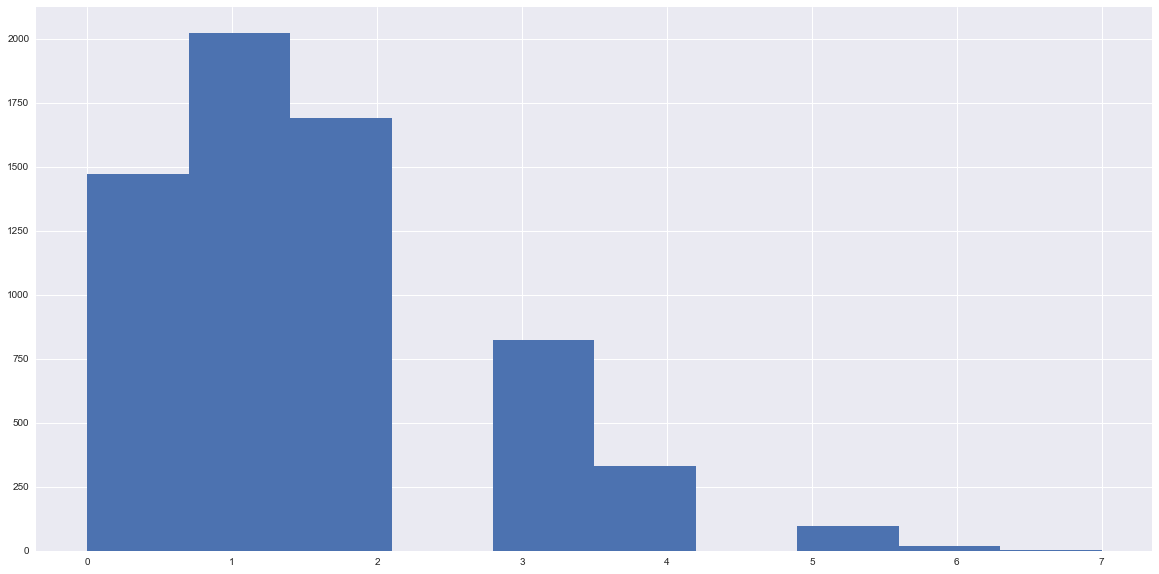

In [168]:
# Home team histogram
plt.hist(df['Total_Home_Cards'], density=False, stacked=True);

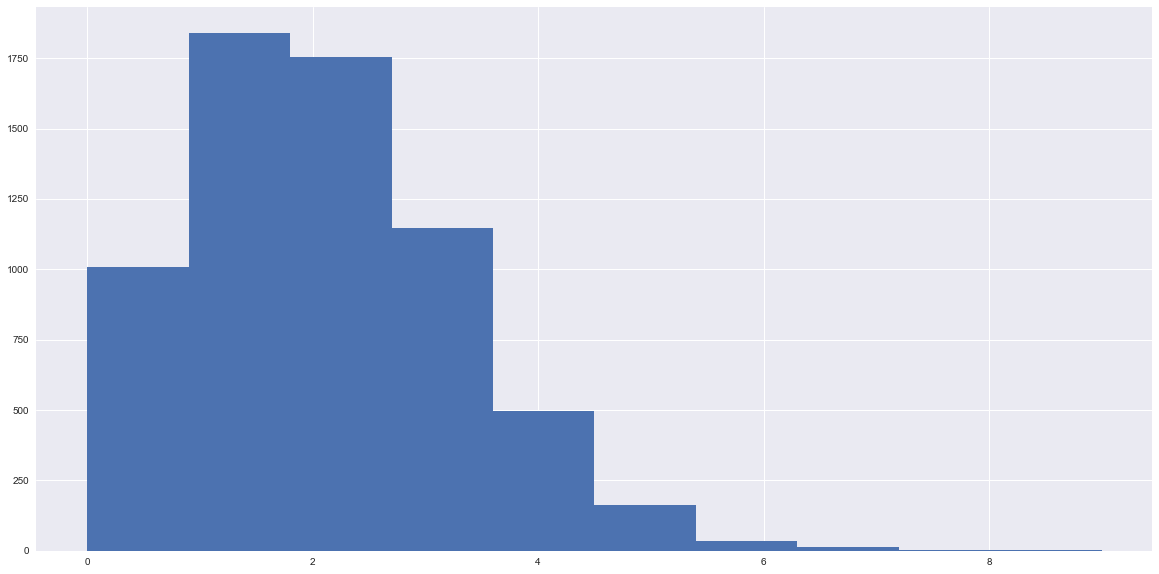

In [170]:
# Away team histogram
plt.hist(df['Total_Away_Cards'], density=False, stacked=True);

In [15]:
(print(f"During the period in question (2005-2021), \
        \nthe away team received a total of {df['Total_Away_Cards'].sum():.0f} cards whilst the home sides only received a total of {df['Total_Home_Cards'].sum():.0f} cards. \
        \nThis is a staggering {df['Total_Away_Cards'].sum() - df['Total_Home_Cards'].sum():.0f} more cards awarded to away sides"))

During the period in question (2005-2021),         
the away team received a total of 11929 cards whilst the home sides only received a total of 9832 cards.         
This is a staggering 2097 more cards awarded to away sides


Looking at this high level breakdown of cards awarded by team whether they were playing home or away we can see overall there is a clear disparity especially amongst the larger clubs where they seem to benefit from an advantage from playing at home.  

There are a few possible reasons for why the bigger sides have a more clear advantage which are listed below:  
- Being a bigger club may introduce unconscious bias into the referees mind as they may feel more pressure when officiating these matches. 
- Bigger clubs tend to have larger stadium capacities with higher home fan attendance, the noise inside the stadium can pressure and influence refereeing decisions. 
- Smaller clubs tend to play aggressive at home and away to remain competitive against teams above them in the table to avoid relegation for example. 

# Hypothesis 

The null hypothesis $H_{0}$ is that there is not referee bias towards home teams in Premier League football matches.  
The alternative hypothesis $H_{1}$ is there the referee is bias towards the home team in Premier League football matches.

## Chi-Squared test

In [20]:
table = [[10, 20, 30],
[6, 9, 17]]
dffoo = pd.DataFrame (table, index=['Male', 'Female'], columns=['Math', 'Physics','Chemistry'])
print("The contingency table: \n", dffoo)
# Conduct chi-squared test to examine whether these two variables,i.e.
# “Gender" (male / female) and "results" (math/physica/chemistry), are
# statistically independent (= null hypothesis) or statistically depdent (=alternative hypothesis)
stat, p, dof, expected = chi2_contingency(table)
print('\nDegree of freedom = %d \n' % dof)
# Expected values
df_expected = pd.DataFrame (expected, index=['Male', 'Female'],columns=['Math', 'Physics', 'Chemistry'])
print("The expected contingency table: \n", df_expected)

prob = 0.95
critical = chi2.ppf(prob, dof)
print('\nprobability=%.3f, critical value=%.3f, chi-square value=%.3f' % (prob, critical, stat))

cards_by_ref_wide = cards_by_ref.pivot_table(index=['Referee'],
                                             columns=['variable'],
                                             values='value')

The contingency table: 
         Math  Physics  Chemistry
Male      10       20         30
Female     6        9         17

Degree of freedom = 2 

The expected contingency table: 
              Math    Physics  Chemistry
Male    10.434783  18.913043  30.652174
Female   5.565217  10.086957  16.347826

probability=0.950, critical value=5.991, chi-square value=0.272


In [25]:
## removing games with 0 no cards shown as this is not useful to measure 
cards_by_ref_wide = cards_by_ref_wide.loc[(cards_by_ref_wide!=0).any(axis=1)]

tablecardstest = cards_by_ref_wide.values.tolist()
stat, p, dof, expected = chi2_contingency(tablecardstest)
print('\nDegree of freedom = %d \n' % dof)
#print(expected)
# Expected values
df_expected = pd.DataFrame (expected, index=cards_by_ref_wide.index,
                            columns=['Away', 'Home',])
#print("The expected contingency table: \n", df_expected)

prob = 0.95
critical = chi2.ppf(prob, dof)
print('\nprobability=%.3f, critical value=%.3f, chi-square value=%.3f' % (prob, critical, stat))

if abs(stat) >= critical:
    print('Gender and result are dependent (reject H0)')
else:
    print('Gender and result are independent (accept H0)\n')

#   interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p-value=%.3f' % (alpha, p))
if p <= alpha:
    print('Gender and result are dependent (reject H0)')
else:
    print('Gender and result are independent (accept H0)')


Degree of freedom = 51 


probability=0.950, critical value=68.669, chi-square value=84.547
Gender and result are dependent (reject H0)
significance=0.050, p-value=0.002
Gender and result are dependent (reject H0)


## OLS (least squared regression)

Intercept of fitted model = 11.2641
Slope of fitted model = 1.1537
                            OLS Regression Results                            
Dep. Variable:                   Away   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2477.
Date:                Fri, 26 Aug 2022   Prob (F-statistic):           2.91e-44
Time:                        18:38:43   Log-Likelihood:                -256.18
No. Observations:                  52   AIC:                             516.4
Df Residuals:                      50   BIC:                             520.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

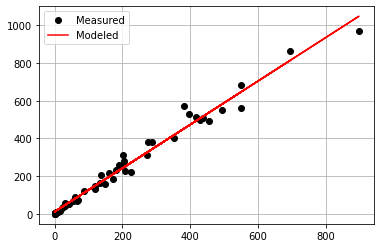

In [34]:
# Define x and y variables
x_data = cards_by_ref_wide.Home
y_data = cards_by_ref_wide.Away

x_label = "Home"
y_label = "Away"

# Fit OLS model to the data. 

formula  = y_label + "~" + x_label
model    = ols(formula = formula, data = cards_by_ref_wide)
model_fit = model.fit()


intercept = model_fit.params['Intercept']
slope = model_fit.params[x_label]

# Print model parameter values with meaningful names, and compare to summary()
print( "Intercept of fitted model = {:0.4f}".format(intercept) )
print( "Slope of fitted model = {:0.4f}".format(slope))
print( model_fit.summary() )

# Use plt.subplots() to create figure and axis objects.
fig, axis = plt.subplots()
# Call axis.plot() to plot data
axis.plot(x_data, y_data, linestyle=" ", marker="o", color="black", label="Measured")

# Call axis.plot() to plot the model
x_fit = x_data
y_fit = intercept + slope * x_data
axis.plot(x_data, y_fit, linestyle="-", marker=None, color="red", label="Modeled")

# Add grid lines and a legend to your plot, and then show to display
axis.grid(True)
axis.legend(loc="best")
plt.show()

## ANOVA tests

F_onewayResult(statistic=206.8381494950363, pvalue=1.5379441106981163e-46) 



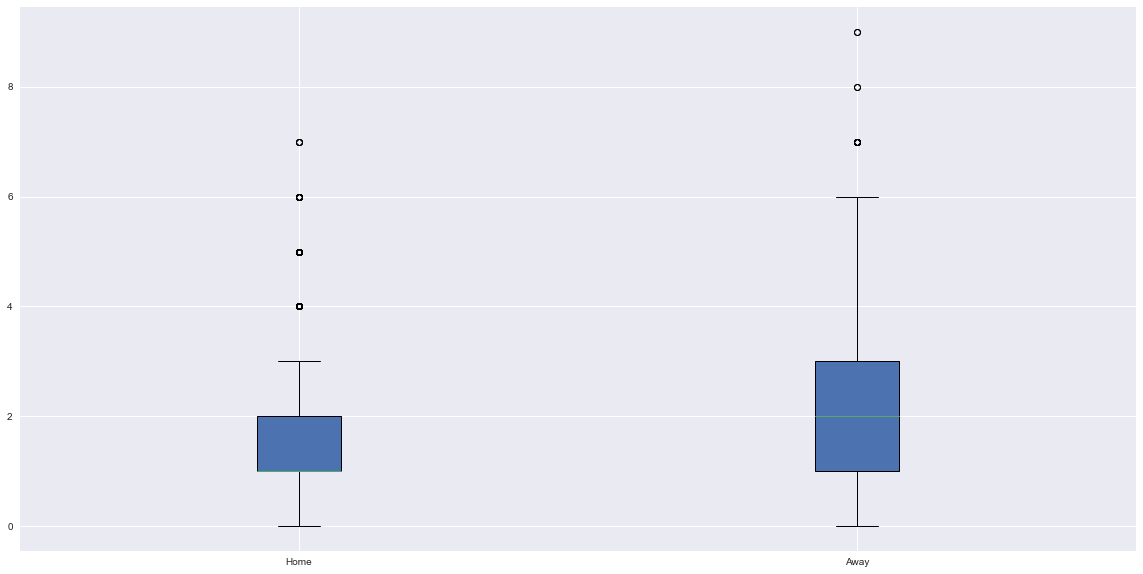

Significant differences exist between the cards shown for home teams vs away teams.
1.5379441106981163e-46


In [112]:
anova = stats.f_oneway(df['Total_Home_Cards'], df['Total_Away_Cards'])

print(anova, "\n")

# Create side-by-side boxplots for the athletes from three countries
box_plot_data=[df['Total_Home_Cards'], df['Total_Away_Cards']]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Home','Away'])
plt.show()

alpha= 0.05
if (anova[1] < alpha):
    print("Significant differences exist between the cards shown for home teams vs away teams.")
else:
    print ("No significant differences exist between the cards shown for home teams vs away teams.")

In the above one way ANOVA tests we experience a p-value less than our significance level of 0.05 or 5% therefore we can say this shows us there is significant differences between the number of total cards (yellow and red combined) shown towards home teams when compared to away teams.  


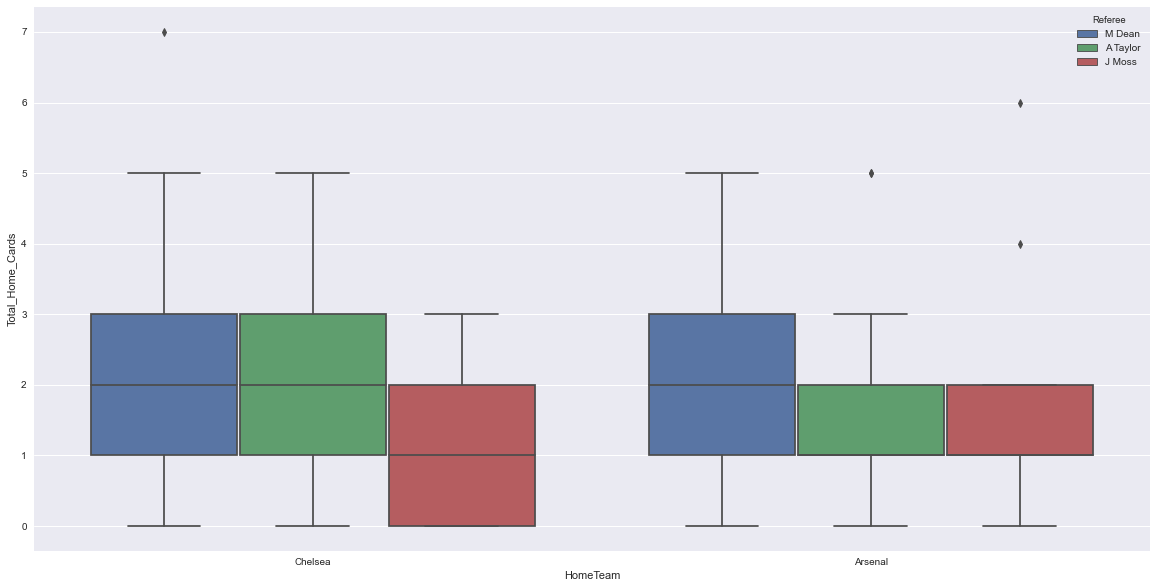

In [128]:

## Filtering referees for top 3 For Arsenal and Chelsea


Top3Refs = ['M Dean', 'A Taylor', 'J Moss']
Top3Refs_df_home = df[df['Referee'].isin(Top3Refs) & df['HomeTeam'].isin(['Arsenal', 'Chelsea'])]

Top3Refs_df_away = df[df['Referee'].isin(Top3Refs) & df['AwayTeam'].isin(['Arsenal', 'Chelsea'])] 

# Focusing on two teams randomly chosen 
Twoteam_home = df[df['HomeTeam'].isin(['Arsenal', 'Chelsea'])]
#Twoteam_away = df[df['AwayTeam'].isin(['Arsenal', 'Chelsea'])]

## Boxplot
sns.set(rc={'figure.figsize':(20,10)})
sns.boxplot(y='Total_Home_Cards', x='HomeTeam',
data=Top3Refs_df_home,
palette="deep", hue='Referee');



               sum_sq     df         F    PR(>F)
Referee     75.783890   36.0  1.110641  0.305355
AwayTeam   120.044562   40.0  1.583368  0.014329
Residual  1078.482164  569.0       NaN       NaN


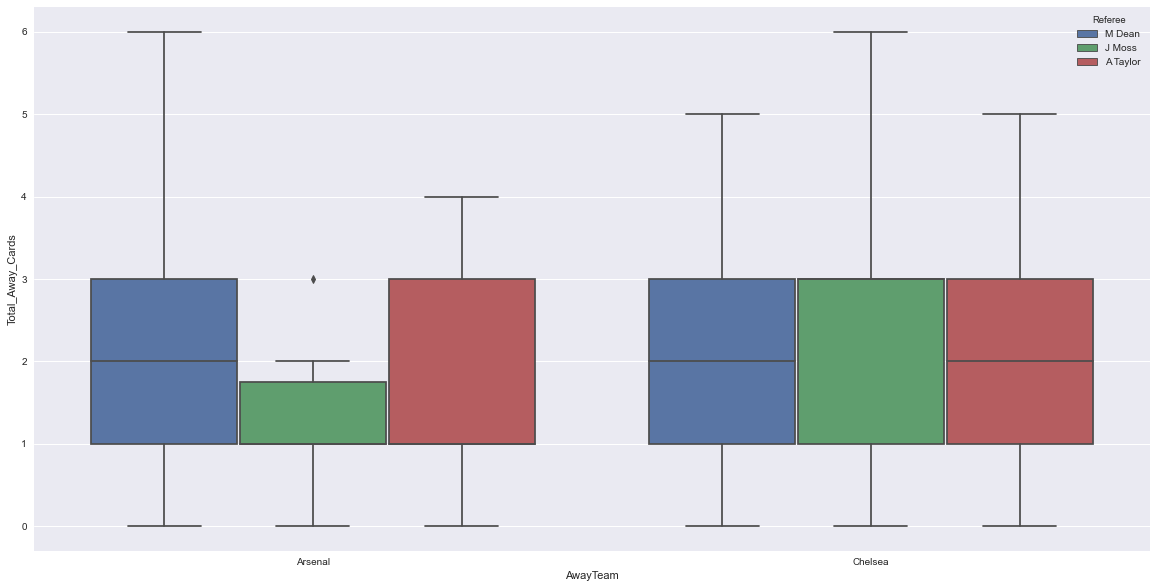

In [129]:
## Boxplot for Away cards
sns.set(rc={'figure.figsize':(20,10)})
sns.boxplot(y='Total_Away_Cards', x='AwayTeam',
data=Top3Refs_df_away,
palette="deep", hue='Referee')

From the above we can see how despite the same officials taking charge of same teams the treatment tends to still vary whether or not they are home or away. 
It is also clear that when both Arsenal and Chelsea play away from home the max cards they receive also shoots up which may occur in a few games but this highlights difference in treatment especially when considering the max cards they may receive at home is significantly lower. 

In [133]:
formula = 'Total_Home_Cards ~ Referee + HomeTeam'
model = smf.ols(formula, data=Twoteam_home).fit()

# Perform two-way ANOVA and print ANOVA table
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

              sum_sq     df         F    PR(>F)
Referee   103.288684   36.0  1.831386  0.002556
HomeTeam    1.763413    1.0  1.125599  0.289137
Residual  952.519366  608.0       NaN       NaN


When comparing results of the two-way ANOVA tests produced for Arsenal and Chelsea based on these teams playing at home. The results show that the p-value for `Referees` is 0.002556 which is much less than the significance level of 0.05 or 5% which indicates there is statistical significance here thus showing how the referee's have an influence over the number of cards (yellow and red) shown to the Home teams.   

We can therefore reject the null hypothesis $H_{0}$ that referees do not have bias towards home teams in the Premier League.

Using the same matches looking at the Away side ANOVA tests we can see that the number of cards shown actually depend on who the Away team is as the p-value for `AwayTeam` is 0.014 which is signficantly less than our 5% significance level.  

## Discussion of results
The only issue here is that when looking at the Away sides I have not chose a similar selection of teams that both Chelsea and Arsenal have faced where the same referees officiated the matches with same opponent so I expect there to be much more variability when it comes to the Away team results. 

# References
<span id="fn1"> 1: Association, T., 2022. Law 5 - The Referee. [online] www.thefa.com. Available at: <https://www.thefa.com/football-rules-governance/lawsandrules/laws/football-11-11/law-5---the-referee> [Accessed 20 August 2022].</span>  

<span id="fn2"> 2: Pappas, C., 2011. Theoretical analysis of referee bias in youth hockey. [online] Digscholarship.unco.edu. Available at: <https://digscholarship.unco.edu/cgi/viewcontent.cgi?article=1069&context=theses> [Accessed 20 August 2022].</span>  

<span id="fn3"> 3: Lim, C. and Rodenberg, R., 2022. Payback Calls: A Starting Point for Measuring Basketball Referee Bias and Impact on Team Performance. [online] Papers.ssrn.com. Available at: <https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1584967> [Accessed 23 August 2022].</span>

<span id="fn4"> 4: Association, F., 2022. Law 12 - Fouls and Misconduct. [online] www.thefa.com. Available at: <https://www.thefa.com/football-rules-governance/lawsandrules/laws/football-11-11/law-12---fouls-and-misconduct> [Accessed 20 August 2022].</span>  

<span id="fn5"> 5: BALMER, N., NEVILL, A. and WILLIAMS, A., 2003. Modelling home advantage in the Summer Olympic Games. Journal of Sports Sciences, [online] 21(6), pp.469-478. Available at: <https://www.researchgate.net/publication/10673396_Modelling_home_advantage_in_the_Summer_Olympic_Games>. </span> 
